# Instructions

This notebook accompanies the final takehome exam.

* Sections that you need to change to receive full credit are surounded with comments like this:
    
```python
############################################
# THIS IS CODE THAT YOU HAVE TO CHANGE
############################################
```

* You are expected to do all of the calculations for the exam by hand and only check your work using this notebook and use this notebook for plotting.

## Submission

To turn this exam in, print out your final notebook using file print (within google colab), or file export to html, print (if using ipython on your computer), and attach it to your handwritten work for the exam. The exam should be submitted in a similar format as homework assignments.

# Functions

In [ ]:
# This installs the control library if you don't have it

In [2]:
!pip install control

In [3]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from numpy import genfromtxt

plt.rcParams['figure.figsize'] = (10, 5)

In [4]:
def power_spectrum(t, d, fmin=0, fmax=30, width=0.5, n=8):
    T = t[-1] - t[0]
    ak = np.fft.ifft(d);
    dt = T/len(d)
    k = np.arange(0, len(d)//n)
    freq = k/T
    plt.bar(freq, np.abs(ak[k]), width=width)
    plt.ylabel('|ak|')
    plt.xlabel('Hz')
    plt.grid()
    ax = plt.gca().set_xlim(fmin, fmax)
    return ak[k], freq

# Simulation Code

In [5]:
def simulate_spacecraft_docking(design_data):
    """
    @param G: The Laplace transform of X/T, x position over thrust
    @param H: Your controller with noise filter.
    """
    G = design_data['G']
    H = design_data['H']
    Ge_r = design_data['Ge_r']
    Ge_n = design_data['Ge_n']
    Ge_d = design_data['Ge_d']
    noise = design_data['noise']
    disturbance = design_data['disturbance']
    t = noise[:, 0]
    reference = 1 + 0.2*t + 0.1*t**2  # the reference trajectory

    # compute output
    e_r = control.forced_response(Ge_r, U=reference, T=t)[1];
    e_n = control.forced_response(Ge_n, U=noise[:, 1], T=t)[1];
    e_d = control.forced_response(Ge_d, U=disturbance[:, 1], T=t)[1];
    e = e_r + e_n + e_d
        
    vx = 1
    t1 = t[-1]
    t0 = t1 - 2
    
    i0 = np.argmax(t > t0)
    
    x0 = vx*t0
    x1 = vx*t1
    
    error_tol = 0.1
    plt.figure(figsize=(10, 5))
    plt.plot(t, e)
    plt.plot(x1, 0, 's', markersize=10, label='space station')
    plt.hlines(error_tol, x0, x1, label='docking window', linewidth=3)
    plt.hlines(-error_tol, x0, x1, linewidth=3)
    plt.grid()
    plt.legend()
    plt.axis('equal')
    plt.xlabel('x error, m')
    plt.ylabel('y error, m')

    if np.any(np.abs(e[i0:]) > error_tol):
        print('CRASH')
    else:
        print('SUCCESSFUL DOCKING')
        
    return locals()

# Design Code

CRASH


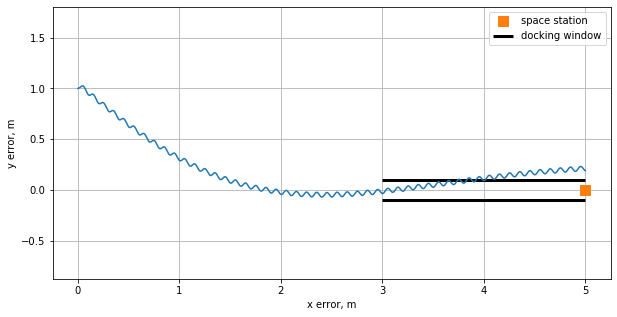

In [6]:
def design():
    
    # load data for noise and disturbance for analysis
    noise = np.loadtxt('data/final_s19_noise.csv', delimiter=',')
    disturbance = np.loadtxt('data/final_s19_disturbance.csv', delimiter=',')

    # constants
    m = 1
    s = control.tf([1, 0], [0, 1])
    G = 1/(m*s**2)

    #########################################
    # ONLY CHANGE K, p, based on your design
    K = 1
    p = 10*2*np.pi

    #########################################
    H_noise_filter = p/(s + p) #control.tf(*scipy.signal.butter(N=2, Wn=Wn, analog=True))
    H_controller = K*(s + 1)
    H = H_controller*H_noise_filter

    # find transfer functions for error, e
    Ge_r = control.minreal(1/(1+G*H), verbose=False)
    Ge_n = control.minreal(G*H/(1+G*H), verbose=False)
    Ge_d = control.minreal(-G/(1+G*H), verbose=False)
    
    return locals()

design_data = design()
sim_data = simulate_spacecraft_docking(design_data);

# Problem 1: Power Spectrum Analysis

noise peaks
	ak:  [0.53992609+0.84153614j]
	frequency:  [10.0020004] Hz


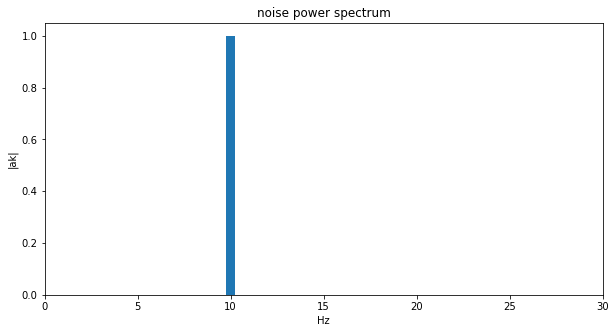

In [7]:
plt.figure(figsize=(10, 5))
ak_noise, freq_noise = power_spectrum(design_data['noise'][:, 0], design_data['noise'][:, 1]);
plt.title('noise power spectrum')
plt.grid()

noise_peaks = np.abs(ak_noise) > 0.01
print('noise peaks\n\tak: ', ak_noise[noise_peaks])
print('\tfrequency: ', freq_noise[noise_peaks], 'Hz')

disturbance peaks
	ak:  [-0.0827916+0.18227518j]
	frequency:  [4.00080016] Hz


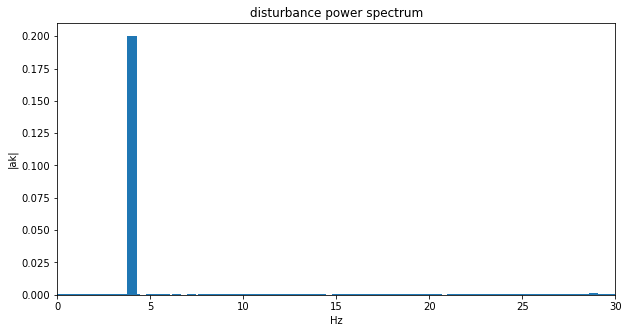

In [8]:
plt.figure(figsize=(10, 5))
ak_dist, freq_dist = power_spectrum(design_data['disturbance'][:, 0], design_data['disturbance'][:, 1]);
plt.title('disturbance power spectrum')
plt.grid()

dist_peaks = np.abs(ak_dist) > 0.01
print('disturbance peaks\n\tak: ', ak_dist[dist_peaks])
print('\tfrequency: ', freq_dist[dist_peaks], 'Hz')

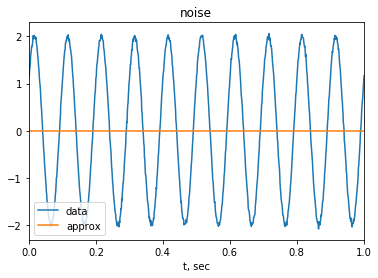

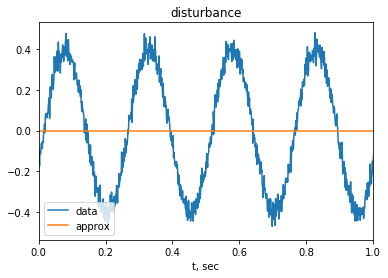

In [9]:
t = design_data['noise'][:, 0]
n = design_data['noise'][:, 1]
d = design_data['disturbance'][:, 1]

######################################################
# Code your noise and disturbance approximations here
n_approx = 0*t
d_approx = 0*t
######################################################

plt.figure()
plt.plot(t, n, label='data')
plt.plot(t, n_approx, label='approx')
plt.gca().set_xlim(0, 1)
plt.xlabel('t, sec')
plt.title('noise')
plt.legend()

plt.figure()
plt.plot(t, d, label='data')
plt.plot(t, d_approx, label='approx')
plt.gca().set_xlim(0, 1)
plt.title('disturbance')
plt.xlabel('t, sec')
plt.legend()


In [10]:
######################################################
# Compute the root mean square error of your signal here
# example: rms_error = np.sqrt(np.mean((y - y_approx)**2))
rms_noise = 0
rms_dist = 0
#####################################################
print('rms_noise', rms_noise)
print('rms_dist', rms_dist)

rms_noise 0
rms_dist 0


# Problem 2: Transfer Functions/ Laplace Transforms

Derive transfer functions by hand.
Set r(s) so that is used for error analysis.

In [11]:
#######################################################################
# Set the Laplace transform of your input here
# example: r_s = 1/s
s = control.tf([1, 0], [0, 1])
r_s = 0  # laplace transform of reference input

#######################################################################

# Problem 3: Bode Plot Analysis

## Noise Filtering Tuning

Design a noise filter that attenuates your lowest noise frequency by 20 dB.

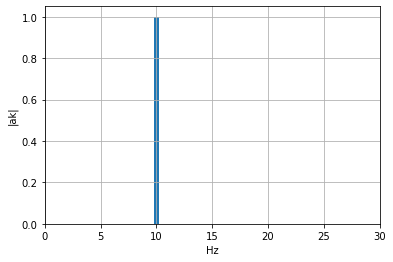

In [12]:
power_spectrum(design_data['noise'][:, 0], design_data['noise'][:, 1]);

You can change this by setting p in design data.

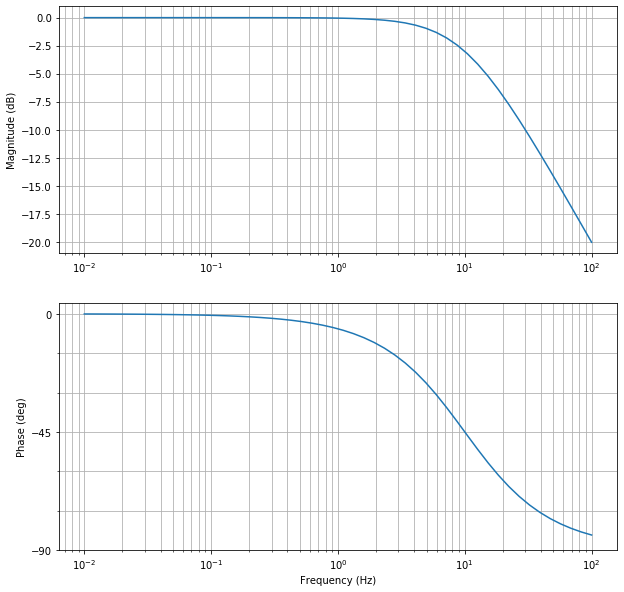

In [13]:
s = control.tf([1, 0], [0, 1])
p = design_data['p']
plt.figure(figsize=(10, 10))
control.bode(p/(s+p), omega=2*np.pi*np.logspace(-2, 2), Hz=True, dB=True);

# Problem 4: Error Analysis

Set the controller gain such that the steady state error is 2 cm.

## Reference Tracking Error

$r(t) = 0.1 + 0.2t + 0.1t^2$

In [14]:
Ge_r = design_data['Ge_r']
s = control.tf([1, 0], [0, 1])
e_r_ss = np.abs(control.minreal(Ge_r*s*r_s, verbose=False)(0))
print("steady state error from reference trajectory: {:0.4g} cm".format(100*e_r_ss))

steady state error from reference trajectory: 0 cm


This bode plots is not necessary for this analysis, but shown below for those interested.

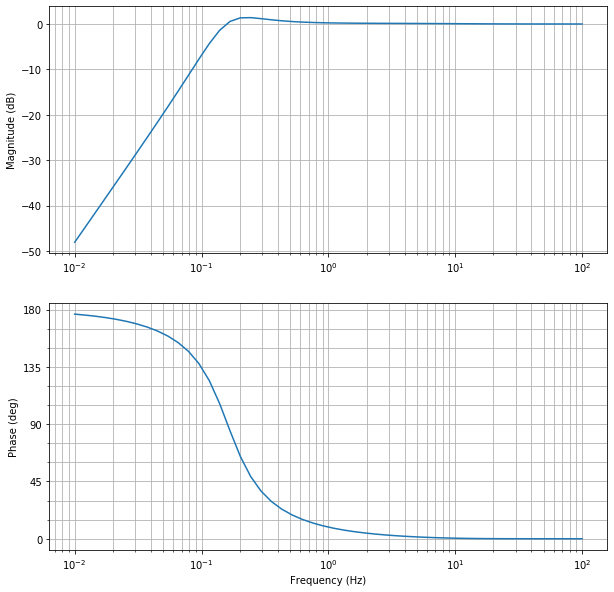

In [15]:
plt.figure(figsize=(10, 10))
control.bode(design_data['Ge_r'], dB=True, Hz=True);

# Noise

Now compute the noise that is transmitted to the error in the system. Since we know K and $\omega$.

The power spectrum is again helpful to look at.

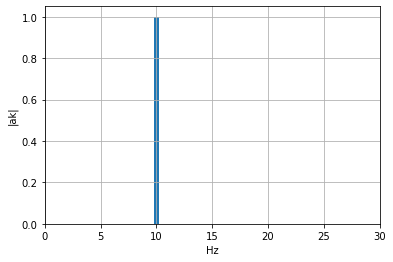

In [16]:
power_spectrum(design_data['noise'][:, 0], design_data['noise'][:, 1]);

In [17]:
Ge_n = design_data['Ge_n']

#######################################################################
# Use the power spectrum to predict the steady state error amplitude due
# to noise, given the transfer function Ge_n
# example: e_n_ss_amp = 4*np.abs(Ge_n(5*2*np.pi*1j))
e_n_ss_amp = 0
#######################################################################


print("steady state noise amplitude in output: {:0.4g} cm".format(100*e_n_ss_amp))

steady state noise amplitude in output: 0 cm


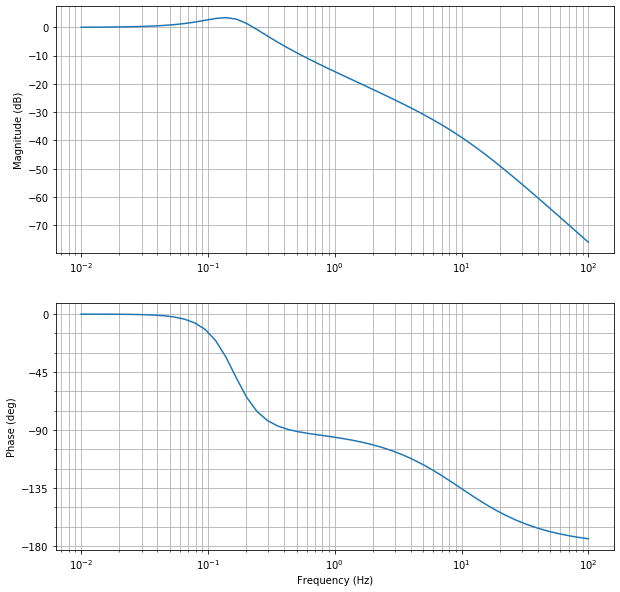

In [18]:
plt.figure(figsize=(10, 10))
plt.hlines(sim_data['error_tol'], sim_data['t'][0], sim_data['t'][-1], colors='r')
plt.hlines(-sim_data['error_tol'], sim_data['t'][0], sim_data['t'][-1], color='r')
control.bode(design_data['Ge_n'], dB=True, Hz=True);

## Disturbance

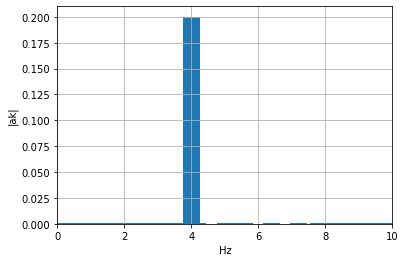

In [19]:
power_spectrum(design_data['disturbance'][:, 0], design_data['disturbance'][:, 1], fmax=10);

In [20]:
Ge_d = design_data['Ge_d']

#######################################################################
# Use the power spectrum to predict the steady state error amplitude due
# to disturbance, given the transfer function Ge_d
# example: e_d_ss_amp = 4*np.abs(Ge_d(5*2*np.pi*1j))
e_d_ss_amp = 0
#######################################################################

print("steady state disturbance amplitude in output: {:0.4g} cm".format(100*e_d_ss_amp))

steady state disturbance amplitude in output: 0 cm


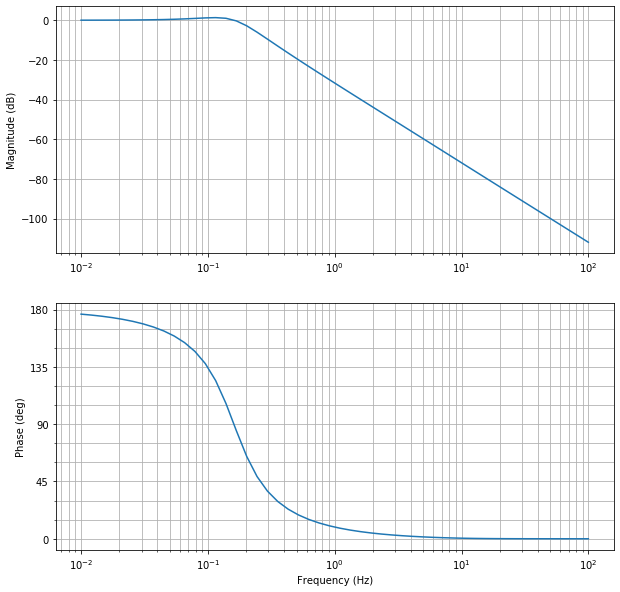

In [21]:
plt.figure(figsize=(10, 10))
control.bode(design_data['Ge_d'], dB=True, Hz=True);

## Steady State Total Error Bound

total error: 0 cm, docking tolerance 10 cm
theory predicts successful docking


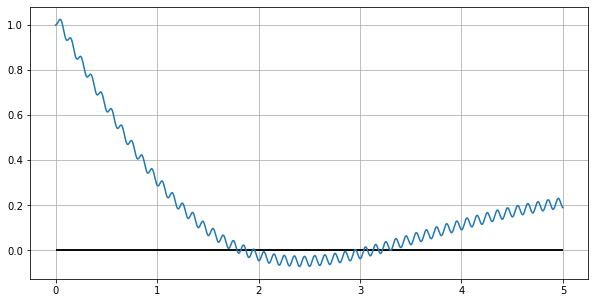

In [22]:
e_total = e_r_ss + e_n_ss_amp + e_d_ss_amp
e_tol = sim_data['error_tol']
print("total error: {:0.4g} cm, docking tolerance {:0.4g} cm".format(100*e_total, 100*e_tol))
if e_total < e_tol:
    print('theory predicts successful docking')
else:
    print('theory predicts crash')
    
plt.figure(figsize=(10, 5))
plt.plot(sim_data['t'], sim_data['e'])
plt.hlines(e_total, sim_data['t'][0], sim_data['t'][-1])
plt.hlines(-e_total, sim_data['t'][0], sim_data['t'][-1])
plt.grid()

# Problem 5: Output Analysis

In [23]:
G = design_data['G']
H = design_data['H']

######################################################
# write your code here for the closed loop
# transfer function computation
Gc = 1/s  # fix this
######################################################

ss = control.tf2ss(Gc)
print('A', ss.A)
print('eig A', np.linalg.eig(ss.A))

A [[0.]]
eig A (array([0.]), matrix([[1.]]))


In [24]:
res_r, res_p, res_k = scipy.signal.residue(Gc. num[0][0], Gc.den[0][0])
res_r, res_p, res_k
print(res_r ,res_p, res_k)

[1.] [0.] [0.]


Text(0.5, 1.0, 'Saw tooth input approximation')

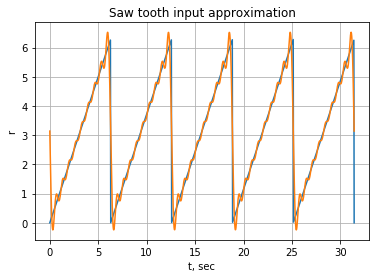

In [25]:
t = np.linspace(0, 10*np.pi, 1000)
r = np.pi*(scipy.signal.sawtooth(t) + 1)
r_approx = np.pi
n = 10 # number of terms
for k in np.arange(1, n):
    r_approx +=  -2*np.sin(k*t)/k
plt.plot(t, r)
plt.plot(t, r_approx)
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('r')
plt.title('Saw tooth input approximation')

Text(0, 0.5, 'y')

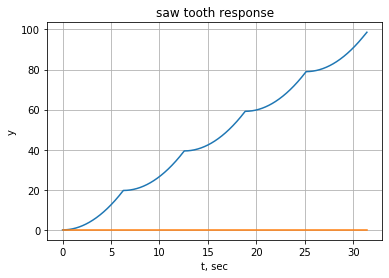

In [26]:
######################################################
# write your code here to compute your approximation 
# of the forced response
y_saw_approx = np.array(0*t, dtype=complex)
for r_j, p_j in zip(res_r, res_p):
    y_saw_approx += 0
    for k in np.arange(1, 100):
        y_saw_approx += 0
y_saw_approx = np.real(y_saw_approx)
######################################################
y_saw = control.forced_response(Gc, T=t, U=r)[1]
plt.plot(t, y_saw, label='simulated')
plt.plot(t, y_saw_approx, label='theoretical approx')
plt.title('saw tooth response')
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('y')